In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from re import sub
import pickle

warnings.filterwarnings('ignore')

In [2]:
# model packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
# from scipy.optimize import minimize

In [3]:
df_clean = pd.read_csv('data/cleanData.csv')
df_clean['zipcode'] = df_clean['zipcode'].astype('category')

In [4]:
# one-hot for categorical column (>= 3 categories)
to_categorical = ['zipcode', 'property_type', 'room_type', 'bed_type', 'peak_month']


df_clean = pd.concat([df_clean, pd.get_dummies(df_clean[to_categorical],
                                              prefix=['zipcode_', 'propertyType_', 'roomType_', 'bedType_', 'peakMonth_'], 
                                              drop_first=True)], axis = 1)

In [5]:
not_features = ['listing_id','date','dayWeek','month','host_since','city', 'year', 'day'] + to_categorical

In [6]:
df_final = df_clean.drop(not_features, axis = 1)

The features we have:
- price_daily
- pull distance (how far the date is from the time pulling the data)
- host info: host_length (when doing optimization for new hosts, set 0)
- time info: weekend, peak_month
- property info: zipcode, property type, room type, bed type, acommodates, bathrooms, bedrooms, beds, guests_included, extra_people
- related fees info: security_deposit, cleaning_fee

## Predictive Model (The probability of getting rent)

In this predictive model, we are finding the mapping for (price, other variables) to (the probability of getting rent)

In [7]:
np.random.seed(2019)
negative_index = df_final[(df_final.pull_distance == 0) & (df_final.unavailable == 0)].index
upsample_index = np.random.choice(negative_index, np.sum(df_final[df_final['pull_distance'] == 0]['unavailable'])-len(negative_index))

df_final = df_final.append(df_final.iloc[upsample_index])

In [11]:
X = df_final.drop(['unavailable'], axis = 1)
Y = df_final['unavailable']

The probability of Being Rent is 0.62


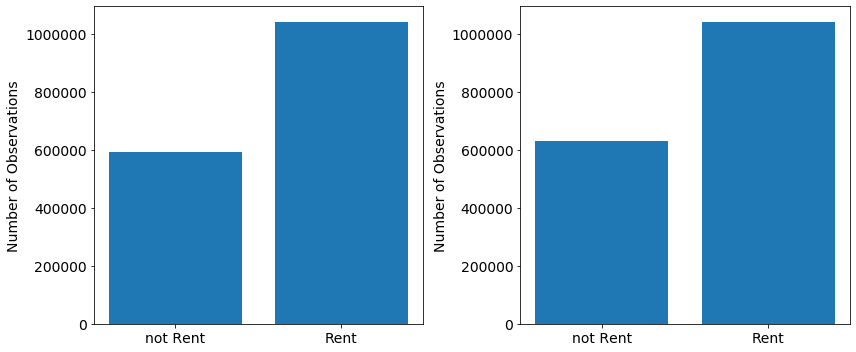

In [19]:
# Data Balance check
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].bar([1,2], [len(Y)-np.sum(Y)-len(upsample_index), np.sum(Y)])
ax[1].bar([1,2], [len(Y)-np.sum(Y), np.sum(Y)])
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['not Rent', 'Rent'])
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel('Number of Observations',fontsize=14)
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['not Rent', 'Rent'])
ax[1].set_ylabel('Number of Observations',fontsize=14)
ax[1].tick_params(labelsize=14)
plt.tight_layout()
print('The probability of Being Rent is {0:4.2f}'.format(np.sum(Y)/len(Y)))

1. Train-Test Split

In [27]:
X_TRAIN, X_test, Y_TRAIN,  y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2019)
# X_train, X_val, y_train,  y_val = train_test_split(X_TRAIN, Y_TRAIN, test_size = 0.2, random_state = 2019)

print('# Training Images: {}'.format(len(X_TRAIN)))
# print('# Validation Images: {}'.format(len(X_val)))
print('# Test Images: {}'.format(len(X_test)))

# Training Images: 1338276
# Test Images: 334569


2. Logistic Regression (with built-in cross validation for selecting Cs values and l1_ratios)

In [12]:
# k = KFold(5, random_state = 2019, shuffle=True)
# clf = LogisticRegressionCV(cv = k, random_state = 2019).fit(X_TRAIN, Y_TRAIN)

In [13]:
# print('The accuracy for Logistic Regression on Test set is {0:6.4f}'.format(clf.score(X_test, y_test)))

3. KNN (with cross validation for selecting n_neighbors)

In [14]:
# knn = KNeighborsClassifier()
# param_grid = {'n_neighbors': np.arange(10, 2, 1)}
# knn_gscv = GridSearchCV(knn, param_grid, cv = k)
# knn_gscv.fit(X_TRAIN, Y_TRAIN)

In [15]:
# # print('The best n_neighbors for KNN is {}'.format(knn_gscv.best_params))
# print('The accuracy for KNN on Test set is {0:6.4f}'.format(knn_gscv.score(X_test, y_test)))

4. LDA/QDA

5. Decision Trees

6. Random Forest

In [71]:
# rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# rf.fit(X_TRAIN, Y_TRAIN);

In [100]:
# pickle.dump(rf, open('randomForest.sav', 'wb'))

In [20]:
rf = pickle.load(open('rf.sav', 'rb'))

In [87]:
print('The accuracy for random forest on Test set is {0:6.4f}'.format(rf.score(X_test, y_test)))

The accuracy for random forest on Test set is 0.9114


In [22]:
rf_featureimp = pd.DataFrame({'Feature':X.columns,'Importance':rf.feature_importances_})
rf_featureimp = rf_featureimp.sort_values(by='Importance',ascending=False).head(20)

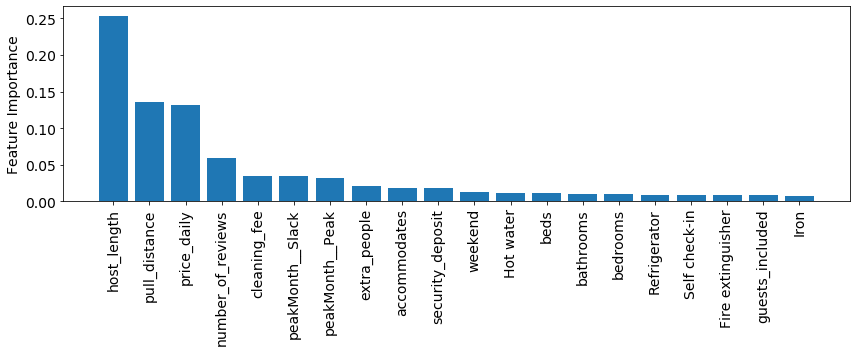

In [25]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
ax.bar(rf_featureimp.Feature, rf_featureimp.Importance)
ax.set_xticklabels(rf_featureimp.Feature,rotation=90)
ax.set_ylabel('Feature Importance',fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('feature_imp.png')

7. Boosting (XGBoost)

## Optimization

In [18]:
# columns_needed = list(X.columns)
# columns_remove = ['price_daily','host_length','pull_distance']

# for i in columns_remove:
#     columns_needed.remove(i) 

# index_Flag = True
# for i in columns_needed:
#     index_Flag &= X[i] == X_blank[i].values[0]

# lb, ub = np.quantile(X[index_Flag].price_daily, (0.5, 0.95))

In [73]:
def get_prob(price):
    X_blank['price_daily'] = price
    prob = rf.predict_proba(X_blank)[0][-1] # use the model here
    return prob

In [74]:
def optimization(lb, ub):
    print('Searching among [{}, {}]'.format(lb, ub))
    optima_sol = {'prob':0, 'price':0, 'Expected Return':0}
    for p in np.arange(lb, ub+1, 1):
        if p* get_prob(p) >= optima_sol['Expected Return']:
            optima_sol = {'prob':get_prob(p), 'price':p, 'Expected Return':p* get_prob(p)}
    return optima_sol

-----------------------

In [75]:
columns_needed = list(X.columns)
columns_remove = ['price_daily','host_length','pull_distance']
for i in columns_remove:
    columns_needed.remove(i) 

In [145]:
X_test_case =  X_test.iloc[1]
X_test_case['host_length'] = 0
X_test_case['pull_distance'] = 0
X_blank = pd.DataFrame(X_test_case).T # use the values in other columns for convenience
X_blank['price_daily'] = 0

In [216]:
def optimization(lb, ub, prob_lower = 0):
    optima_sol = {'prob':0, 'price':0, 'Expected Return':0}    
#     print('Searching among [{}, {}]'.format(lb, ub))
    for p in np.arange(lb, ub+1, 1):
        prob = get_prob(p)
        if prob >= prob_lower:
            if p* prob >= optima_sol['Expected Return']:
                optima_sol = {'prob':prob, 'price':p, 'Expected Return':p* prob}
    if optima_sol['price'] == 0: # interpolate where we have little data points
        a = (1-get_prob(lb))/lb**2
        p = int(((1-prob_lower)/a)**(1/2))
        optima_sol = {'prob':prob_lower, 'price':p, 'Expected Return':p* prob_lower}
    return optima_sol

In [214]:
def whole_process(userCase, prob_lower):
    index_Flag = True
    for i in columns_needed:
        index_Flag &= X[i] == userCase[i].values[0]

    lb, ub = np.quantile(X[index_Flag].price_daily, (0.05, 0.95))
    return optimization(lb, ub, prob_lower)
    
    

In [217]:
whole_process(X_blank, 0.9)

{'prob': 0.9, 'price': 127.0, 'Expected Return': 114.3}

---------------------------------

In [48]:
# def get_prob(price):
#     X_blank = input_testcase(price)
#     prob = rf.predict_proba(X_blank)[0][-1] # use the model here
#     return prob

In [49]:
# def minimize_objective(price):
#     return - price * get_prob(price)

In [55]:
# def get_constraints():
#     columns_needed = list(X.columns)
#     columns_remove = ['price_daily','host_length','pull_distance']
    
#     X_blank = input_testcase(0)

#     for i in columns_remove:
#         columns_needed.remove(i) 
        
#     index_Flag = True
#     for i in columns_needed:
#         index_Flag &= X[i] == X_blank[i].values[0]
    
#     return np.quantile(X[index_Flag].price_daily, (0.5, 0.95))
        

In [56]:
# initial_price = 100
# # solution = minimize(minimize_objective, initial_price, method = 'SLSQP', tol = 1e-6, bounds = [get_constraints()])
# solution = minimize(minimize_objective, initial_price, method = 'SLSQP', tol = 1e-6, bounds = [(90,150)])

# print('The Suggested Price is {0:4.2f}'.format(solution.x[0]))
# print('The Expected Return is {0:4.2f}, with the probability of being rent is {1:4.2f}'.format(-solution.fun, get_prob(solution.x)))

The Suggested Price is 170.00
The Expected Return is 85.00, with the probability of being rent is 0.50
